<a href="https://colab.research.google.com/github/raywangruihua/raywangruihua/blob/main/notebooks/test_Cellpose-SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cellpose-SAM: superhuman generalization for cellular segmentation

Marius Pachitariu, Michael Rariden, Carsen Stringer

[paper](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1) | [code](https://github.com/MouseLand/cellpose)

This notebook explains processing example 2D and 3D images using the Cellpose package on Google Colab using the GPU.

### Make sure you have GPU access enabled by going to Runtime -> Change Runtime Type -> Hardware accelerator and selecting GPU

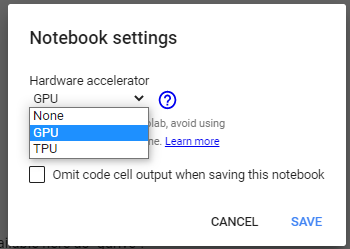

### Install Cellpose-SAM

In [1]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-7998_0we
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-7998_0we
  Resolved https://www.github.com/mouseland/cellpose.git to commit 15eb3c6831ac19e0948dbc38c11016d11d1aacf3
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 62.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   

Check GPU and instantiate model - will download weights.

In [3]:
import numpy as np
from cellpose import models, core, io, plot
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt

io.logger_setup() # run this to get printing of progress

#Check if colab notebook instance has GPU access
if core.use_gpu()==False:
  raise ImportError("No GPU access, change your runtime")

model = models.CellposeModel(gpu=True)

2025-06-16 12:05:33,899 [INFO] WRITING LOG OUTPUT TO /root/.cellpose/run.log
2025-06-16 12:05:33,899 [INFO] 
cellpose version: 	4.0.5.dev23+g15eb3c6 
platform:       	linux 
python version: 	3.11.13 
torch version:  	2.6.0+cu124
2025-06-16 12:05:33,901 [INFO] ** TORCH CUDA version installed and working. **
2025-06-16 12:05:33,902 [INFO] ** TORCH CUDA version installed and working. **
2025-06-16 12:05:33,903 [INFO] >>>> using GPU (CUDA)
2025-06-16 12:05:36,279 [INFO] >>>> loading model /root/.cellpose/models/cpsam


### Download example images

100%|██████████| 21.3M/21.3M [00:00<00:00, 24.3MB/s]
100%|██████████| 1.63M/1.63M [00:00<00:00, 3.49MB/s]


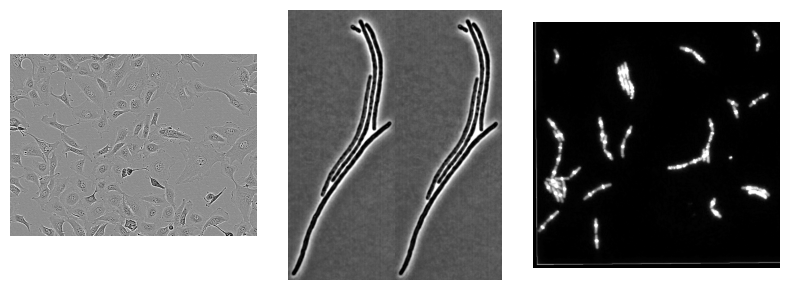

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import utils, io

# download example 2D images from website
url = "http://www.cellpose.org/static/data/imgs_cyto3.npz"
filename = "imgs_cyto3.npz"
utils.download_url_to_file(url, filename)

# download 3D tiff
url = "http://www.cellpose.org/static/data/rgb_3D.tif"
utils.download_url_to_file(url, "rgb_3D.tif")

# unzip images
dat = np.load(filename, allow_pickle=True)["arr_0"].item()

imgs = dat["imgs"]
masks_true = dat["masks_true"]

plt.figure(figsize=(8,3))
for i, iex in enumerate([9, 16, 21]):
    img = imgs[iex].squeeze()
    plt.subplot(1,3,1+i)
    plt.imshow(img[0], cmap="gray", vmin=0, vmax=1)
    plt.axis('off')
plt.tight_layout()
plt.show()

### Run Cellpose-SAM

In [6]:
masks_pred, flows, styles = model.eval(imgs, niter=1000) # using more iterations for bacteria


2025-06-16 12:08:07,792 [INFO] 8%|8         | 2/24 [00:05<00:58,  2.66s/it]


KeyboardInterrupt: 

plot results

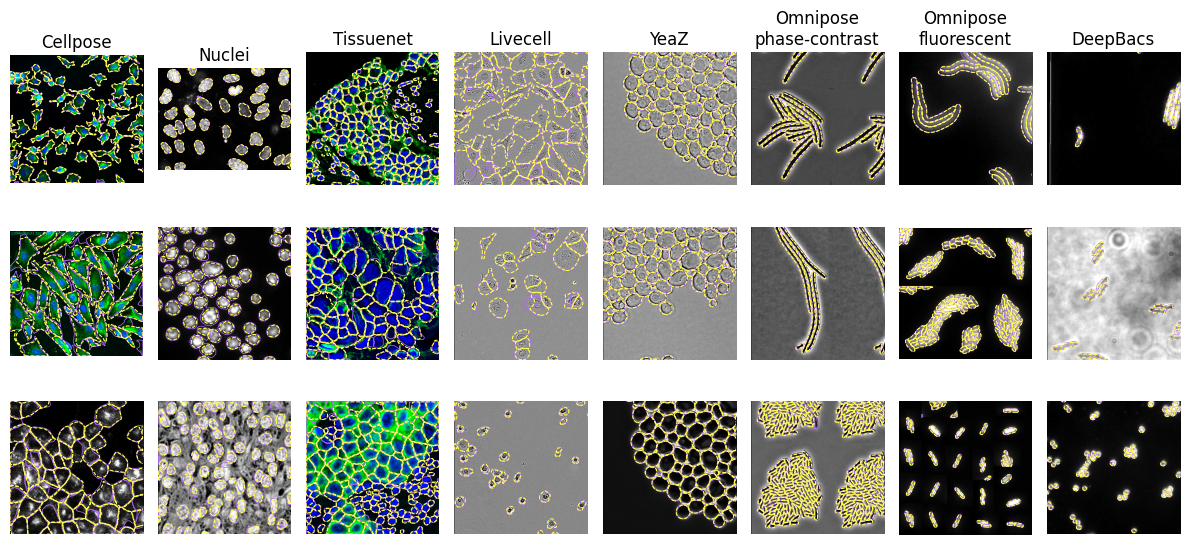

In [7]:
from cellpose import transforms, plot

titles = [
        "Cellpose", "Nuclei", "Tissuenet", "Livecell", "YeaZ",
         "Omnipose\nphase-contrast", "Omnipose\nfluorescent",
        "DeepBacs"
    ]

plt.figure(figsize=(12,6))
ly = 400
for iex in range(len(imgs)):
    img = imgs[iex].squeeze().copy()
    img = np.clip(transforms.normalize_img(img, axis=0), 0, 1) # normalize images across channel axis
    ax = plt.subplot(3, 8, (iex%3)*8 + (iex//3) +1)
    if img[1].sum()==0:
        img = img[0]
        ax.imshow(img, cmap="gray")
    else:
        # make RGB from 2 channel image
        img = np.concatenate((np.zeros_like(img)[:1], img), axis=0).transpose(1,2,0)
        ax.imshow(img)
    ax.set_ylim([0, min(400, img.shape[0])])
    ax.set_xlim([0, min(400, img.shape[1])])


    # GROUND-TRUTH = PURPLE
    # PREDICTED = YELLOW
    outlines_gt = utils.outlines_list(masks_true[iex])
    outlines_pred = utils.outlines_list(masks_pred[iex])
    for o in outlines_gt:
        plt.plot(o[:,0], o[:,1], color=[0.7,0.4,1], lw=0.5)
    for o in outlines_pred:
        plt.plot(o[:,0], o[:,1], color=[1,1,0.3], lw=0.75, ls="--")
    plt.axis('off')

    if iex%3 == 0:
        ax.set_title(titles[iex//3])

plt.tight_layout()
plt.show()

# Run Cellpose-SAM in 3D

There are two ways to run cellpose in 3D, this cell shows both, choose which one works best for you.

First way: computes flows from 2D slices and combines into 3D flows to create masks



In [ ]:
img_3D = io.imread("rgb_3D.tif")


# 1. computes flows from 2D slices and combines into 3D flows to create masks
masks, flows, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                batch_size=32,
                                do_3D=True, flow3D_smooth=1)


Second way: computes masks in 2D slices and stitches masks in 3D based on mask overlap

Note stitching (with stitch_threshold > 0) can also be used to track cells over time.

In [ ]:
# 2. computes masks in 2D slices and stitches masks in 3D based on mask overlap
print('running cellpose 2D + stitching masks')
masks_stitched, flows_stitched, _ = model.eval(img_3D, z_axis=0, channel_axis=1,
                                                  batch_size=32,
                                                  do_3D=False, stitch_threshold=0.5)

Results from 3D flows => masks computation

In [ ]:
# DISPLAY RESULTS 3D flows => masks
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)

Results from stitching

In [ ]:
# DISPLAY RESULTS stitching
plt.figure(figsize=(15,3))
for i,iplane in enumerate(np.arange(0,75,10,int)):
  img0 = plot.image_to_rgb(img_3D[iplane, [1,0]].copy(), channels=[2,3])
  plt.subplot(1,8,i+1)
  outlines = utils.masks_to_outlines(masks_stitched[iplane])
  outX, outY = np.nonzero(outlines)
  imgout= img0.copy()
  imgout[outX, outY] = np.array([255,75,75])
  plt.imshow(imgout)
  plt.title('iplane = %d'%iplane)